# Imports 

In [1]:
from pdb import run
from unittest import case
import emcee
import corner
import pickle
from tqdm import tqdm
import numpy as np
from qutip import *
from multiprocess import Pool
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, basinhopping
from IPython.display import display, Math
from scipy.stats import chi2
from protocolsClass import Hamiltonian_Fitter,State
import matplotlib.pyplot as plt
from functions import SpinSystem
 


# Measurement Data

In [2]:
ground_meas_old_Nb = np.array([7512786.3, 6847127.7, 6180056.7, 5510661.7, 4837199., 4156107.7, 3459061.2, 2730533.1, 1787541.6]) * 1e-3 # [kHz]
manu_ramsey_meas_old_Nb = np.array([-134296, -133678, -132898, -131896, -130532, -128697, -125952, -124533, -88889]) * 1e-3 # [kHz] previous
best_x_old =  [
        449.8217895516637,
        129.90322492463346,
        -237.05198836433365,
        -11.942209580809898,
        -149.3165679361477,
        1.5721261153027557,
        -0.8193213318825887,
        0.07781602296853966
    ]
ground_meas_Nb = np.array([7560562.0 ,6894745.1 ,6227459.8 , 5557759.9 , 4883861.9 ,4202128.8 , 3504133.1, 2774604.8, 1822491.2]) * 1e-3
manu_ramsey_meas_Nb = np.array([-136547.1, -135922.4, -135196.4, -134203.1, -132831.5, -130986.4, -128470.1, -122551.2, -128756.7])* 1e-3

ground_meas_Ca = np.array([997843.4 ,1090793.4 ,1185442.1 ,1281215.1 ,1377750.3 ,1474814.6 ,1572254.3])*1e-3
manu_ramsey_meas_Ca = np.array([-27703.3,-27670.2,-27594.3,-27518.5,-27449.3,-27376.6,-27349.6])*1e-3

d_ground_meas_Ca = np.array([0.0273, 0.0249, 0.0277, 0.0283, 0.0286, 0.0409, 0.0654])*1e-3# [kHz]
d_manu_ramsey_meas_Ca = np.array([5.7657,5.5012, 5.8450, 5.3050, 6.7760, 8.1508, 13.7237])*1e-3# [kHz]
full_meas_Ca = np.concatenate((ground_meas_Ca,manu_ramsey_meas_Ca))
d_full_meas_Ca = np.concatenate((d_ground_meas_Ca,d_manu_ramsey_meas_Ca))



full_meas_Nb = np.concatenate((ground_meas_Nb,manu_ramsey_meas_Nb))
full_meas_old_Nb = np.concatenate((ground_meas_old_Nb,manu_ramsey_meas_old_Nb))

d_ground_meas_Nb = np.array([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0002, 0.0002, 0.0002])# [kHz]
d_manu_ramsey_meas_Nb = np.array([0.0450, 0.0298, 0.0236, 0.0285, 0.0223,  0.0182, 0.0159, 0.0195, 0.0175])# [kHz]
d_full_meas_Nb = np.concatenate((d_ground_meas_Nb,d_manu_ramsey_meas_Nb))
A_perp_meas_Nb = 55 # [kHz] | Measured through the Raman Rabi experiment
A_perp_meas_Ca = 20 # [kHz] | Measured through the Raman Rabi experiment
A_simu_Nb = np.array([[-436.6,    0.,   -41.3],
                    [  -0.,  -448.4,    0. ],
                    [ -88.5,    0.,   129.8]])

A_simu_Nb = 1e3*np.array([[ 0.43899564,  0.,          0.02076148],
                    [-0.,          0.44172529, -0.        ],
                    [-0.04857903,  0.,          0.12994526]])


exp_id = '_Ca_meas'

fitter_ca = Hamiltonian_Fitter(full_meas_Ca,d_full_meas_Ca,system=SpinSystem(I=7/2,S=1/2), meas_Aperp = A_perp_meas_Ca,simu_A= A_simu_Nb,id = exp_id)


def _sig_decimals(err, sig_figs=2):
    """
    Return the number of decimals needed to keep `sig_figs`
    significant figures of an uncertainty `err`.

    Example:
    err = 0.0123  -> 3  (0.012 shown with 2 s.f.)
    err = 3.4     -> -1 ( 3  shown with 2 s.f.)
    """
    if err == 0:
        return 0
    exponent = int(np.floor(np.log10(err)))
    return max(0, sig_figs - 1 - exponent)

def pretty_mcmc(flat_samples, labels, sig_figs=2):
    """
    Print median and asymmetric 1-σ errors with only the
    relevant digits for each parameter.
    """
    ndim = flat_samples.shape[1]

    for i in range(ndim):
        p16, p50, p84 = np.percentile(flat_samples[:, i], [16, 50, 84])
        q_minus, q_plus = p50 - p16, p84 - p50
        # Use the larger side as a conservative uncertainty
        err = max(q_minus, q_plus)
        ndp = _sig_decimals(err, sig_figs)

        fmt = f"{{:.{ndp}f}}"
        central = fmt.format(p50)
        low    = fmt.format(q_minus)
        high   = fmt.format(q_plus)

        # build LaTeX string
        txt = (rf"\mathrm{{{labels[i]}}}"
               rf" = {central}_{{-{low}}}^{{+{high}}}")
        display(Math(txt))

# Fitted Values and Guesses

In [6]:


best_x_ground = [460.5432325817811,-237.3531938224631,149.44397764618174,2.676920410881122,-0.07979116163000531]
best_x_excited = [447.72559654611877,-237.23552163653977,149.53908329962314,6.419823433715284,0.3084357146817395]


guess_full_old = [449.8217895516637,129.90322492463346,-237.05198836433365,-11.942209580809898,-149.3165679361477,1.5721261153027557,-0.8193213318825887,0.07781602296853966]
    
best_x =  [ 4.49821745e+02,  1.29897714e+02 ,-2.37052323e+02, -1.19458723e+01, -1.49320580e+02,  1.57442624e+00, -8.21616775e-01 , 7.88331359e-02]
median_x =  [ 4.49821749e+02,  1.29897911e+02, -2.37052291e+02, -1.19454405e+01, -1.49320418e+02,  1.57449384e+00, -8.21746234e-01,  7.89184735e-02]

# Ground

In [7]:
best_x_ground = [460.54324141019123,-237.35318307038176,149.44386682482926,2.6761209774725265,-0.0775147693909858]
best_x_ground_Ca =  [ 4.46771094e+02  ,3.19950251e+01  ,4.90867382e-01  ,6.58374345e+00 ,-4.35601519e-01]
fitter_ground.run_MCMC(best_x_ground_Ca,nsteps = 5000,var = 0.01)

KeyboardInterrupt: 

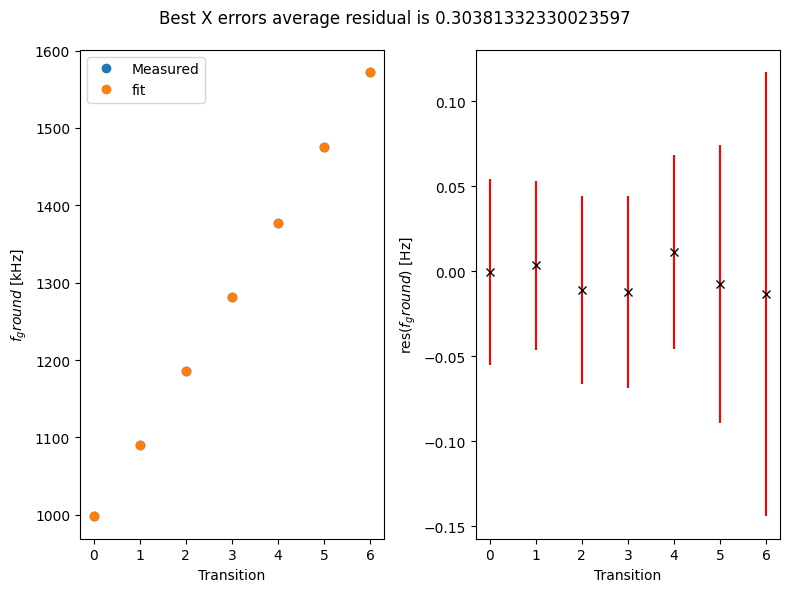

In [ ]:
fitter_ground.Plot_Best()

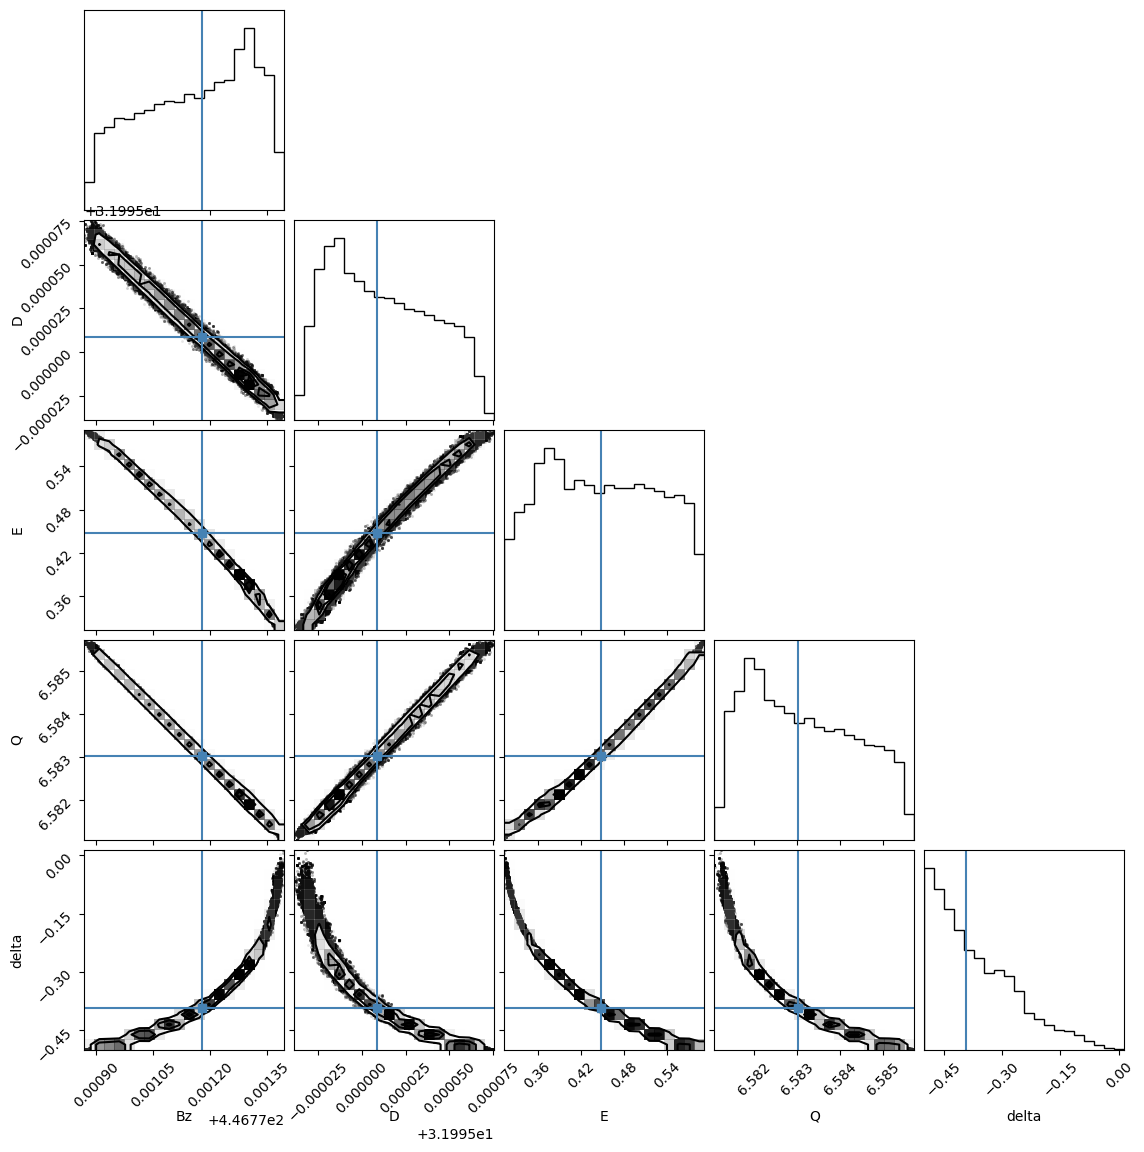

In [ ]:
fitter_ground.Plot_corner()

[[ 1.100000e-01 -1.678000e+01  1.200000e-01]
 [ 1.200000e-01 -1.610000e+01  1.100000e-01]
 [ 3.700000e-04  3.288732e+01  4.900000e-04]]


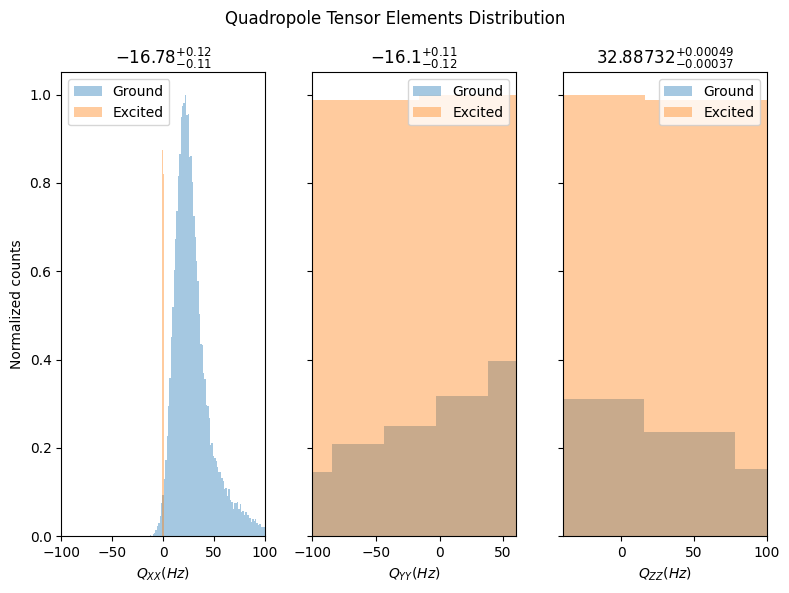

In [ ]:
fitter_ground.Plot_Quadropole()

# excited

100%|██████████| 5000/5000 [04:48<00:00, 17.32it/s]


median x :  [4.46770075e+02 3.19963798e+01 1.45959683e+00 6.61527822e+00
 1.58414862e-01]
best x :  [ 4.46772005e+02  3.19959041e+01  1.10797247e+00  6.59794846e+00
 -3.94003539e-02]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

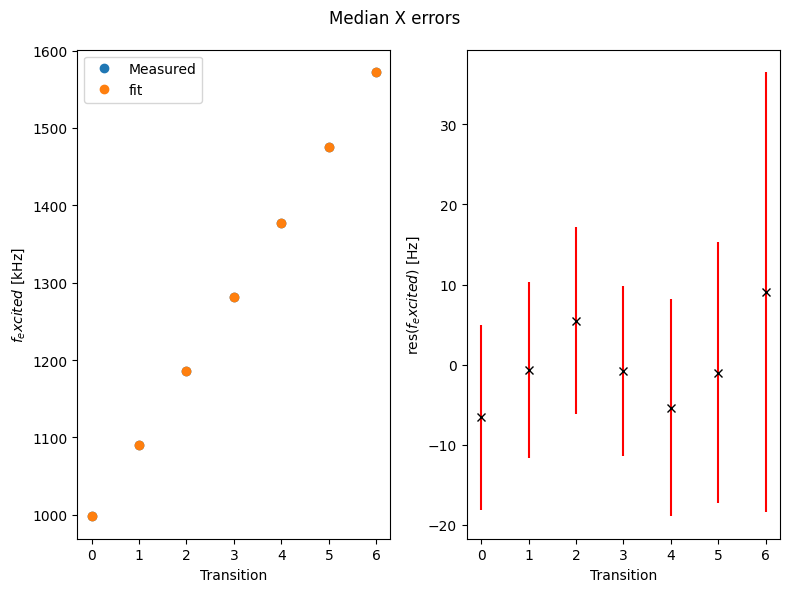

In [ ]:
best_x_excited = [447.72559654611877,-237.23552163653977,149.53908329962314,6.419823433715284,0.3084357146817395]
best_x_excited_Ca =  [4.46771895e+02 ,3.19958784e+01, 1.13483532e+00, 6.59973890e+00, 1.37588701e-01]
fitter_excited.run_MCMC(best_x_excited,nsteps=5000)


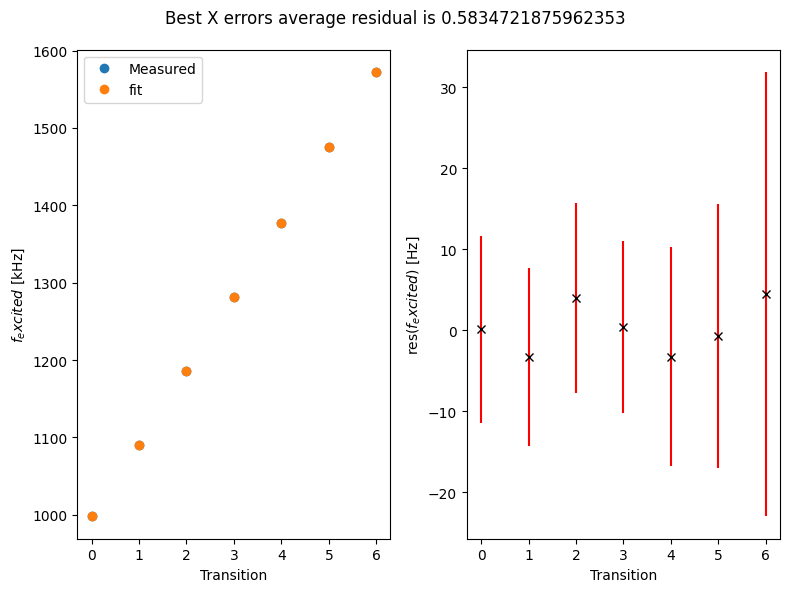

In [ ]:
fitter_excited.Plot_Best()

In [ ]:
fitter_excited.Save_results()

In [ ]:
fitter_excited.Load_results()

File mcmc_results_full_Ca_meas.json not found. Skipping loading full state results.


[[ 1.100000e-01 -1.678000e+01  1.200000e-01]
 [ 1.200000e-01 -1.610000e+01  1.100000e-01]
 [ 3.700000e-04  3.288732e+01  4.900000e-04]]


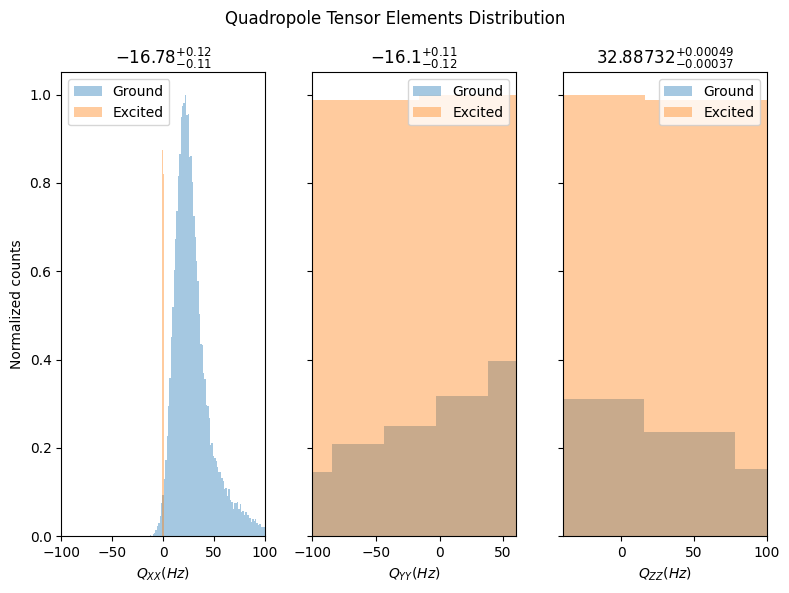

In [ ]:
fitter_excited.Plot_Quadropole()


# Full

In [ ]:
best_x =  [ 4.60735120e+02 , 1.33454486e+02 ,-2.37473628e+02 ,149.5887879e+00,
 2.677151815e+00 , 1.17723572e+00 ,-8.98114801e-01,  2.22202185e-03]
best_x = [ 4.54105879e+02 , 1.33576768e+02 ,-2.37322064e+02 ,-4.56419403e+00,
 -1.49445865e+02,  1.17575176e+00, -8.95192592e-01 , 1.53291163e-03]
best_x =  [ 4.54105995e+02 , 1.33573315e+02, -2.37322081e+02 ,149,2.677, -0.08, 0.1 , 0.001,0]

best_x = [ 4.54131243e+02,  1.33490645e+02 ,-2.37297266e+02 ,-4.34098426e+00,
 -1.49434569e+02,  1.42745043e+00, -7.84097996e-01 , 7.24745420e-02]

fitter_ca.run_MCMC(best_x,nwalkers=64,nsteps = 5000,var = 0.01)

ValueError: operands could not be broadcast together with shapes (8,) (15,) 

In [ ]:
fitter_full.Load_results()

File mcmc_results_full_Ca_meas.json not found. Skipping loading full state results.


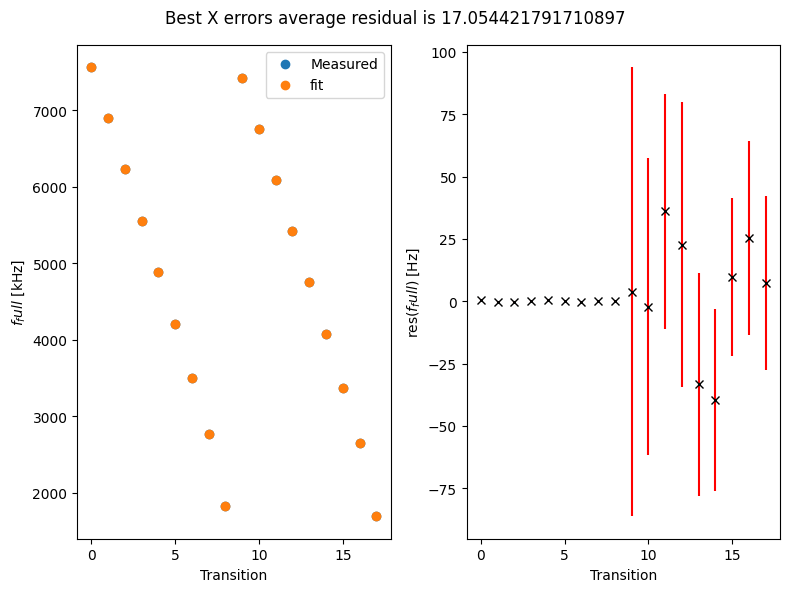

In [ ]:
fitter_full.Plot_Best()

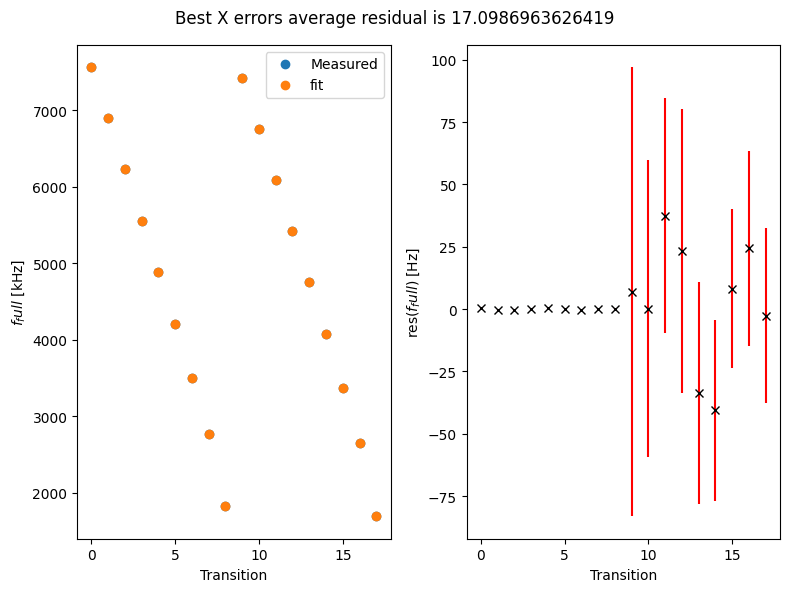

In [ ]:
fitter_full.Plot_Best()

c:\Users\manipp4\Documents\Leons_stuff\Spectroscopy_Hamiltonian_fitter-\protocolsClass.py:252: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(meas_to_plot[:9], 'o', marker = 'v', label= r"$\omega^{\downarrow}_{{n(n+1)}/2\pi}$", color = 'orange')
c:\Users\manipp4\Documents\Leons_stuff\Spectroscopy_Hamiltonian_fitter-\protocolsClass.py:253: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(meas_to_plot[9:], 'o', marker = '^', label= r"$\omega^{\uparrow}_{{n(n+1)}/2\pi}$", color = 'blue')
c:\Users\manipp4\Documents\Leons_stuff\Spectroscopy_Hamiltonian_fitter-\protocolsClass.py:260: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorb

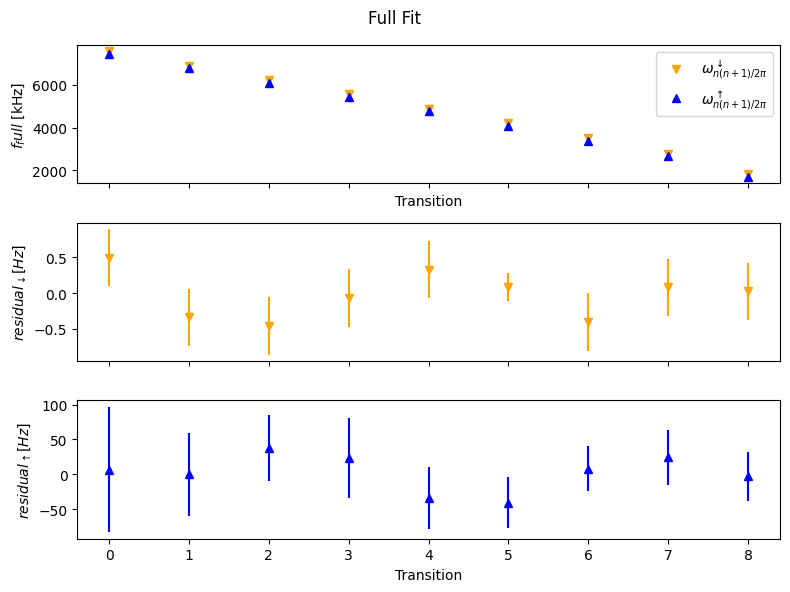

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
fitter_full.Plot_full(fitter_full.best_x['full'])
fitter_full.Print_values()

In [ ]:
samples = fitter_ground.results['ground']
# labels = ["Bz", "A", "D", "S1", "S2", "delta", "alpha", "Dz"]
labels = ["Bz", "D", "E", "Q", "delta"]

pretty_mcmc(samples,labels,sig_figs=1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Quadropole Plotting

File mcmc_results_full_Ca_meas.json not found. Skipping loading full state results.
[[ 1.100000e-01 -1.678000e+01  1.200000e-01]
 [ 1.200000e-01 -1.610000e+01  1.100000e-01]
 [ 3.700000e-04  3.288732e+01  4.900000e-04]]


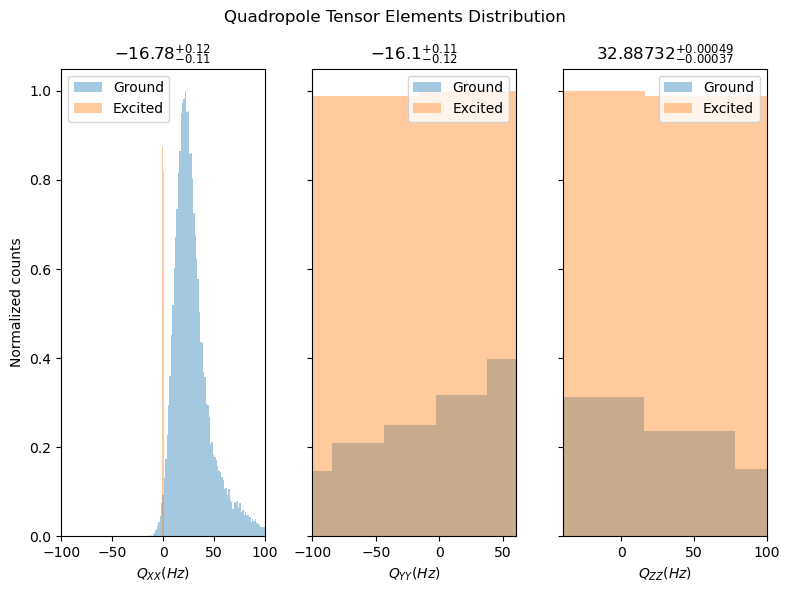

In [ ]:

fitter_full = Hamiltonian_Fitter(full_meas,d_full_meas,State.Full, meas_Aperp = A_perp_meas,simu_A= A_simu,id = exp_id)
fitter_full.Load_results()
#fitter_full.Plot_corner()
fitter_full.Plot_Quadropole()

AttributeError: 'NoneType' object has no attribute 'get_chain'